# Week 10 - Clustering 1

For Week 10, include the following ideas: k-means; specifically elbow method, Silhouette score, feature scaling, and distance metrics.

#### <font color='plum'> ANSWERS IN THIS COLOR

# Imports

In [329]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import kagglehub 
import time

from sklearn.cluster            import KMeans
from sklearn.experimental       import enable_halving_search_cv  # Needed to explicitly require this experimental feature
from sklearn.model_selection    import HalvingGridSearchCV # now import normally from model_selection

# from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    RepeatedStratifiedKFold, 
    GridSearchCV, 
    # HalvingGridSearchCV,
    RandomizedSearchCV, 
    RepeatedKFold, 
    cross_val_predict, 
    cross_validate, 
    StratifiedKFold, 
    KFold
)

from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    root_mean_squared_error,
    accuracy_score, 
    balanced_accuracy_score,
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    average_precision_score, 
    make_scorer, 
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    silhouette_score,
    adjusted_rand_score,
    
)
from sklearn.decomposition  import PCA
from sklearn.preprocessing  import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble       import RandomForestClassifier
from sklearn.datasets       import make_regression
from datetime               import datetime, timedelta
from tqdm                   import tqdm
from typing                 import Any, Dict, List, Union, Tuple
from sklearn.base           import BaseEstimator
from collections            import Counter
from scipy.stats            import randint
from imblearn.over_sampling import SMOTE


%matplotlib inline

from kagglehub              import KaggleDatasetAdapter

sns.set_theme(font_scale=0.8) 
# plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.titlesize']  = 10
plt.rcParams['axes.labelsize']  = 8
plt.rcParams['lines.linewidth'] = 0.5
# plt.rcParams['lines.markersize'] = 3
plt.rcParams['axes.edgecolor']  = 'gray'
plt.rcParams['xtick.color']     = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8

# Utility Functions

In [330]:
# globals
RANDOM_STATE    = 42
n_jobs          = -1
font_size       = 8
TEST_SIZE      = 0.2


In [331]:
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

#### plot_roc_auc_curve

In [332]:

def plot_roc_auc_curve(classifier, X_test, y_test, title='ROC AUC Curve', ax=None):
    y_proba = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")
    plt.tight_layout()
    return ax

#### plot_precision_recall_curve

In [333]:


def plot_precision_recall_curve(classifier, X_test, y_test, title='Precision-Recall Curve', ax=None):
    # Get predicted probabilities for the positive class
    y_proba = classifier.predict_proba(X_test)[:, 1]
    
    # Compute precision-recall pairs and average precision score
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    
    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots()
    
    # Plot the precision-recall curve
    ax.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend(loc="lower left")
    plt.tight_layout()
    
    return ax


#### plot_confusion_matrix

In [334]:

def plot_confusion_matrix(y_true, y_pred, model_name, labels, ax = None):
    font_size = 10
    plt.rcParams.update({"font.size": font_size})
    cm = confusion_matrix(y_true, y_pred)

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3))

    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", ax=ax,
                xticklabels=labels, yticklabels=labels)

    # Add TP, TN, FP, FN labels
    height, width = cm.shape
    label_matrix = [["TN", "FP"], ["FN", "TP"]]
    for i in range(height):
        for j in range(width):
            ax.text(j + 0.5, i + 0.7, f"\n{label_matrix[i][j]}", 
                    ha='center', va='center', color='white', fontsize=8, fontweight='bold')

    ax.set_title(f"Confusion Matrix - {model_name}\n {labels}")
    ax.set_xlabel("Predicted", fontsize=font_size)
    ax.set_ylabel("True", fontsize=font_size)
    plt.tight_layout()
    return ax




#### plot_feature_importance

In [335]:

def plot_feature_importance(search, X, title="Feature Importance", color="midnightblue", ax=None):
    """
    Plots a horizontal bar chart of feature importances from the best estimator in a search object,
    sorted in descending order (most important features at the top).

        Parameters:
            - search: A fitted GridSearchCV or RandomizedSearchCV object with a tree-based estimator.
            - X: pandas DataFrame of features used to train the model.
            - title: str, title of the plot.
            - color: str, color of the bars.
            - ax: matplotlib Axes object, optional. If None, a new figure and axes will be created.
    """
    # Get  best model from the search object
    best_model = search.best_estimator_

    # Check if  model has feature_importances_ attribute
    if not hasattr(best_model, "feature_importances_"):
        raise AttributeError("The best estimator does not have 'feature_importances_' attribute.")

    # Extract and sort feature importances
    importances         = best_model.feature_importances_
    sorted_indices      = np.argsort(importances)[::-1]
    sorted_features     = X.columns[sorted_indices]
    sorted_importances  = importances[sorted_indices]

    # Create plot if no Axes object is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    ax.barh(sorted_features, sorted_importances, color=color)
    ax.invert_yaxis()  # Most important features at the top
    ax.set_xlabel("Importance")
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


#### plot_metrics

In [336]:
def plot_metrics(param, 
                 parameter_list, 
                 cv_accuracies, 
                 train_accuracies, 
                 test_accuracies, 
                 std_cvs, 
                 best_index, 
                 model_name
                 ):
    """Plots the accuracy and standard deviation metrics."""
    plt.rcParams.update({"font.size": font_size})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 5), sharex=True)
    
    # Use only as many parameter values as computed
    partial_param_list = parameter_list[:len(cv_accuracies)]
    
    # Check if our parameter list is Boolean for proper labeling
    is_boolean      = all(isinstance(val, bool) for val in partial_param_list)
    if is_boolean: 
        # Convert booleans to integer indices for plotting
        x_vals      = list(range(len(partial_param_list)))
        x_labels    = [str(val) for val in partial_param_list]
    else:
        x_vals      = partial_param_list
        x_labels    = partial_param_list
    
    metric = 'Accuracy'

    # ----- First plot: Accuracy ----------------------------------------------------------
    ax1.set_title(f"{model_name} | {metric} vs {param}")
    
    ax1.plot(x_vals, cv_accuracies, marker = '.', label = f"CV {metric}", color = 'midnightblue')
    ax1.plot(x_vals, train_accuracies, marker = '.', label = f"Train {metric}", color = 'green')
    ax1.plot(x_vals, test_accuracies, marker = '.',  label = f"Test {metric}", color = 'orange')
    ax1.scatter([x_vals[best_index]], [cv_accuracies[best_index]], marker='x', s = 100, label = f"Best CV {metric}", color = 'red')
    
    ax1.set_ylabel(metric)
    ax1.legend()
    ax1.grid()
    
    # ----- Second plot: CV Standard Deviation ----------------------------------------------------------
    ax2.set_title(f"{model_name} | CV Standard Deviation vs {param}")
    ax2.plot(x_vals, std_cvs, marker='.', label = f"CV {metric} Std", color = 'midnightblue')
    ax2.set_xlabel(param)
    ax2.set_ylabel("Standard Deviation")
    ax2.legend()
    ax2.grid(alpha = 0.5)
    
    # If using boolean x-values, set custom ticks
    if is_boolean:
        ax2.set_xticks(x_vals)
        ax2.set_xticklabels(x_labels)
    
    plt.tight_layout()
    plt.show()


#### check_early_stopping

In [337]:
def check_early_stopping(mean_cv_accuracy, best_accuracy, no_improve_count, delta, n_iter_no_change):
    """Checks if early stopping criteria are met."""
    if mean_cv_accuracy > best_accuracy + delta:
        best_accuracy = mean_cv_accuracy
        no_improve_count = 0
    else:
        no_improve_count += 1
    
    if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
        print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
        return True, best_accuracy, no_improve_count
    
    return False, best_accuracy, no_improve_count

#### get_parameter_list

In [338]:
# def get_parameter_list(parameter: str,  
#                        custom_list: list, 
#                        df: pd.DataFrame
#                        ):
    
#     """
#     Returns a list of parameter values based on the given parameter name, using a dictionary.

#         Args:
#             parameter: name of the parameter.
#             custom_list: Optional list of custom values, which will override the values in parameter_dict.
#             df: Optional DataFrame, used for calculating total features for 'max_features'.

#         Returns:
#             A list of parameter values.
#     """

#     parameter_dict = {
#         'n_estimators': list(np.arange(50, 1001, 50)),
#         'max_samples': [1.0],
#         'max_depth': [None] + list(np.arange(2, 17, 2)),
#         'bootstrap': [True, False],
#         'learning_rate': list(np.arange(.01, .50, .05)),
#         'min_samples_size': list(np.arange(1, 11)),
#         'min_samples_leaf': list(np.arange(1, 11))
#     }

#     if custom_list is not None:
#         parameter_dict[parameter] = custom_list

#     if parameter == 'max_features':
#         if df is None:
#             raise ValueError("DataFrame 'df' is required to calculate 'max_features'.")
#         if parameter_dict.get('max_features') is not None:
#             return parameter_dict['max_features']
#         else:
#             total_features = df.shape[1]
#             return list(range(2, total_features)) # or list(range(18, total_features+1)), or any other range you wish.
    
#     elif parameter in parameter_dict:
#         return parameter_dict[parameter]
    
#     else:
#         return []
    

#### run_model

In [339]:
# def run_model(
#     model:          Union[BaseEstimator, type],  # The model or model class
#     show_accuracy:  bool,  # score by Accuracy if Classification task else by MSE
#     X_train:        np.ndarray,  # Training feature set
#     y_train:        np.ndarray,  # Training target set
#     X_test:         np.ndarray,  # Testing feature set
#     y_test:         np.ndarray,  # Testing target set
#     n_repeats:      int     = 10,  # Number of repeats for cross-validation
#     cv_folds:       int     = 5,  # Number of k cross-validation folds
#     n_jobs:         int     = -1,  # Number of jobs to run in parallel
#     exp_factor:     float   = 1,  # Exponent factor for MSE values
#     classification_dict     = None,
#     **model_params: Any  # Additional parameters for the model

# ) -> Tuple[float, float, float, float, int, int]:

#     """
#     Runs a machine learning model with specified parameters and performs cross-validation. If task = Classification, plots a confusion matrix.

#         Parameters:
#             - model: The machine learning model or model class to be used.
#             - show_accuracy: Boolean flag to score by accuracy if classification task else by MSE.
#             - X_train: Training feature set as a NumPy array.
#             - y_train: Training target set as a NumPy array.
#             - X_test: Testing feature set as a NumPy array.
#             - y_test: Testing target set as a NumPy array.
#             - n_repeats: Number of repeats for cross-validation (default is 10).
#             - cv_folds: Number of k cross-validation folds (default is 5).
#             - n_jobs: Number of jobs to run in parallel (default is -1).
#             - exp_factor: Exponent factor for MSE values (default is 1).
#             - classification_dict: Dictionary for classification labels (default is None).
#             - **model_params: Additional parameters for the model.

#         Returns:
#             - Tuple containing mean and standard deviation of cross-validation scores, training and testing scores,
#               number of iterations, and number of cross-validation folds.
#     """

#     # Remove extra key used to store error metric, if it was added to the parameter dictionary
#     if 'accuracy_found' in model_params:
#         model_params = model_params.copy()
#         model_params.pop('accuracy_found', None)

#     # Instantiate the model if a class is provided
#     if isinstance(model, type):
#         model = model(**model_params)
#     else:
#         model.set_params(**model_params) # Setting params for an instance

#     decimals = 4 # Number of decimal places to round to
#     # Use RepeatedStratifiedKFold for classification to preserve class distribution
#     # Perform 5-fold cross-validation using accuracy as the scoring metric

#     if show_accuracy:
#         cv_scores = cross_val_score(model,
#                                     X_train,
#                                     y_train,
#                                     scoring = 'accuracy',
#                                     n_jobs  = n_jobs,
#                                     cv      = RepeatedStratifiedKFold(n_splits      = cv_folds,
#                                                                       n_repeats     = n_repeats,
#                                                                       random_state  = 42  # Use a fixed random_state
#                                                                     ),
#                     )

#         mean_cv_accuracy = round(np.mean(cv_scores), decimals)
#         std_cv_accuracy  = round(np.std(cv_scores), decimals)

#         # Fit the model on the full training set
#         model.fit(X_train, y_train)

#         iterations  = n_repeats
#         cv_folds    = cv_folds

#         # Compute training and testing accuracy
#         train_preds     = model.predict(X_train)
#         train_accuracy  = round(accuracy_score(y_train, train_preds), decimals)
#         test_preds      = model.predict(X_test)
#         test_accuracy   = round(accuracy_score(y_test, test_preds), decimals)


#         return mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy, iterations, cv_folds

#     else:
#         neg_mse_scores = cross_val_score(model,
#                                      X_train,
#                                      y_train,
#                                      scoring    = 'neg_mean_squared_error',
#                                      cv         = RepeatedKFold(n_splits = 5, n_repeats = n_repeats, random_state = 42),
#                                      n_jobs     = n_jobs
#                                      )

#         mse_scores  = (-neg_mse_scores) ** exp_factor
#         mean_cv_mse = round(np.mean(mse_scores),3)
#         std_cv_mse  = round(np.std(mse_scores), 3)

#         # Fit the model on the full training set
#         model.fit(X_train, y_train)

#         # Compute training MSE and testing MSE
#         train_preds = model.predict(X_train)
#         train_mse   = round(mean_squared_error(y_train, train_preds) ** exp_factor, 3)
#         test_preds  = model.predict(X_test)
#         test_mse    = round(mean_squared_error(y_test, test_preds) ** exp_factor, 3)

#         return mean_cv_mse, std_cv_mse, train_mse, test_mse, iterations, cv_folds


#### sweep_parameter

In [340]:
# def sweep_parameter(model,
#                     Parameters:     dict,
#                     param:          str,
#                     parameter_list: list,
#                     X_train:        np.ndarray,
#                     y_train:        np.ndarray,
#                     X_test:         np.ndarray,
#                     y_test:         np.ndarray,
#                     verbose          = True,
#                     show_rmse        = False,
#                     show_accuracy    = True,
#                     n_iter_no_change = None,
#                     delta            = 0.001,
#                     n_jobs           = -1,
#                     n_repeats        = 10,
#                     cv_folds         = 5,
#                     classification_dict = None
#                     ) -> Dict[str, Any]:

#     """
#         Sweeps a specified parameter of a Classification machine learning model and evaluates performance metrics.

#             Arguments:
#                 - model:            The machine learning model or model class to be used.
#                 - Parameters:       Dictionary of model parameters.
#                 - param:            The parameter to sweep.
#                 - parameter_list:   List of values to test for the specified parameter.
#                 - X_train:          Training feature set.
#                 - y_train:          Training target set.
#                 - X_test:           Testing feature set.
#                 - y_test:           Testing target set.
#                 - verbose:          If True, prints detailed output and plots results (default is True).
#                 - show_rmse:        If True, shows RMSE instead of MSE (default is True).
#                 - n_iter_no_change: Number of iterations with no improvement to trigger early stopping (default is None).
#                 - delta:            Minimum change in MSE to qualify as an improvement (default is 0.001).
#                 - n_jobs:           Number of jobs to run in parallel for cross-validation (default is -1, using all processors).
#                 - n_repeats:        Number of repeats for cross-validation (default is 10).
#                 - cv_folds:         Number of k cross-validation folds (default is 5).
#                 - classification_dict: Dictionary for classification labels (default is None).

#             Returns:
#                 - Parameters: Updated dictionary of model parameters with the best parameter value found and additional information.
#     """

#     decimals                = 4
#     start                   = time.time()
#     Parameters              = Parameters.copy()  # Avoid modifying the original dictionary

#     print(f"Running {model.__name__} with {param} sweep...\n")

#     cv_accuracies, std_cvs, train_accuracies, test_accuracies = [], [], [], []
#     no_improve_count        = 0
#     best_accuracy           = -np.inf  # since higher accuracy is better
#     best_test_preds         = None # To store best predictions for confusion matrix

#     # Run over each value in parameter_list
#     for p in tqdm(parameter_list, desc = f"Sweeping {param}"):
#         Parameters[param]   = p
#         P_temp              = Parameters.copy()
#         # Remove accuracy_found if present, just in case
#         P_temp.pop('accuracy_found', None)

#         # run_model should return: mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy
#         mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy, iterations, cv_folds = run_model(
#             model               = model,
#             show_accuracy       = show_accuracy,
#             X_train             = X_train,
#             y_train             = y_train,
#             X_test              = X_test,
#             y_test              = y_test,
#             n_repeats           = n_repeats,
#             cv_folds            = cv_folds,
#             n_jobs              = n_jobs,
#             exp_factor          = 0.5 if show_rmse else 1,
#             classification_dict = classification_dict,
#             **P_temp
#         )
#         print(f"{param} = {p}: CV_mean_accuracy = {mean_cv_accuracy:,.{decimals}f}, Train_accuracy = {train_accuracy:,.{decimals}f}, Test_accuracy = {test_accuracy:,.{decimals}f}")

#         cv_accuracies.append(mean_cv_accuracy)
#         std_cvs.append(std_cv_accuracy)
#         train_accuracies.append(train_accuracy)
#         test_accuracies.append(test_accuracy)

#        # Early-stopping logic: maximize accuracy
#         if mean_cv_accuracy > best_accuracy + delta:
#             best_accuracy       = mean_cv_accuracy
#             no_improve_count    = 0

#             # Get test predictions for best model
#             model_instance      = model(**P_temp) # Instantiate with current best params
#             model_instance.fit(X_train, y_train)  # Fit the model with the best parameters
#             best_test_preds     = model_instance.predict(X_test)
#         else:
#             no_improve_count    += 1

#         if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
#             print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
#             break

#     # Identify best parameter
#     max_cv_accuracy                 = max(cv_accuracies)
#     max_index                       = cv_accuracies.index(max_cv_accuracy)
#     best_param                      = parameter_list[max_index]
    
#     Parameters['Test_Param']        = param
#     Parameters[param]               = best_param
#     Parameters['Model']             = model.__name__

#     Parameters['Best_CV_Accuracy']  = round(max_cv_accuracy, decimals)
#     Parameters['Test_Accuracy']     = round(test_accuracies[max_index], decimals)

#     Parameters['n_repeats']         = n_repeats
#     Parameters['cv_folds']          = cv_folds

#     end                             = time.time()
#     execution_time                  = format_hms(end - start)
#     Parameters['execution_time']    = execution_time
#     timestamp                       = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
#     Parameters['timestamp']         = timestamp

# #### GENERATE PLOTS #####
#     if verbose:
#         plot_metrics(param, parameter_list, cv_accuracies, train_accuracies, test_accuracies, std_cvs, max_index, Parameters['Model'])

#         print(f"\nBest {param} found: {best_param}")
#         print(f"Best_CV_Accuracy: {max_cv_accuracy:,.{decimals}f}")
#         print(f"Test_Accuracy: {round(test_accuracies[max_index], decimals)}")
        
#         print("Classification Report:-----------------\n", classification_report(y_test, best_test_preds))
#         # Plot CONFUSION MATRIX for best model ############################
#         # if show_accuracy and best_test_preds is not None:
#         #     fig, ax     = plt.subplots()
            
#         #     class_names = get_classification_labels(classification_dict)

#         #     plot_confusion_matrix(y_test, best_test_preds, Parameters['Model'], class_names, Parameters['Test_Param'],  ax = ax)
#         #     plt.show()

#     # Print timestamp and run-time of successful execution
#     print(f'Execution time: {execution_time}')
#     print("Execute successfully at:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end)))

#     return Parameters

#### run_GridSearch_RandomizedSearch_CV

In [341]:

import inspect


def run_GridSearch_RandomizedSearch_CV(
    ensemble_model,
    dataset_name: str,
    parameter_grid: dict,
    X: pd.DataFrame,
    X_train,
    y_train,
    X_test,
    y_test,
    classification_dict: dict,
    CV_tuning_strategy:             int = 0,  # 0=Randomized, 1=HalvingGrid, 2=Grid
    is_classifier:                  bool = True,
    iterations:                     int = 10,
    n_jobs:                         int = -1,
    verbose:                       bool = True,
    n_repeats:                     int = 10,
    cv_folds:                      int = 5,
    random_state:                  int = None,
    scoring_metric:                str = 'accuracy',  # e.g., 'accuracy', 'f1', 'roc_auc'
    halving_factor:                int = 2,
    is_imbalanced:                  bool = False
) -> tuple:
    """
    Consolidated function for hyperparameter tuning using GridSearchCV, RandomizedSearchCV, or HalvingGridSearchCV.
    """

    # Initialize model with random_state if supported
    if isinstance(ensemble_model, type):
        model_init_params = inspect.signature(ensemble_model).parameters
        if 'random_state' in model_init_params:
            model = ensemble_model(random_state=random_state)
        else:
            model = ensemble_model()
    else:
        model = ensemble_model

    model_name = model.__class__.__name__

    # Common search parameters
    search_params = {
        'n_jobs':               n_jobs,
        'verbose':              verbose,
        'cv':                   cv_folds,
        'scoring':              scoring_metric,
        'return_train_score':   True,
        'estimator':            model
    }

    # Select search strategy
    if CV_tuning_strategy == 0:
        search_type = 'RandomizedSearchCV'
        print(f"Using {search_type}...")
        search = RandomizedSearchCV(
            param_distributions = parameter_grid,
            n_iter              = iterations,
            random_state        = random_state,
            **search_params
        )
    elif CV_tuning_strategy == 1:
        search_type = 'HalvingGridSearchCV'
        print(f"Using {search_type} with halving factor {halving_factor}...")
        search = HalvingGridSearchCV(
            param_grid          = parameter_grid,
            factor              = halving_factor,
            **search_params
        )
    elif CV_tuning_strategy == 2:
        search_type = 'GridSearchCV'
        print(f"Using {search_type}...")
        search = GridSearchCV(
            param_grid          = parameter_grid,
            **search_params
        )
    else:
        raise ValueError("CV_tuning_strategy must be 0 (Randomized), 1 (HalvingGrid), or 2 (Grid).")

    # Fit and evaluate
    start   = time.time()
    search.fit(X_train, y_train)
    end     = time.time()

    cv_results_df = pd.DataFrame(search.cv_results_)

    print(f"\nBest Parameters: {search.best_params_}")
    best_score = search.best_score_
    print(f"Best CV Score ({scoring_metric}): {best_score:,.4f}")

    y_pred = search.best_estimator_.predict(X_test)

    # Handle imbalanced datasets
    if is_imbalanced:
        print("Dataset is imbalanced. Using balanced accuracy.\n")
        test_score = balanced_accuracy_score(y_test, y_pred)
    else:
        test_score = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_score:,.4f}")

    execution_time  = format_hms(end - start)
    timestamp       = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    print(f"Execution Time: {execution_time} seconds")
    print(f'Completed at: {timestamp}')

    # Classification report and plots
    if is_classifier:
        print(f"\n{model_name} - {search_type}\nClassification Report:\n{classification_report(y_test, y_pred, digits=4)}")

        train_preds     = search.best_estimator_.predict(X_train)
        train_accuracy  = balanced_accuracy_score(y_train, train_preds) if is_imbalanced else accuracy_score(y_train, train_preds)
        print(f"Train Accuracy: {train_accuracy:,.4f}")
        print(f"Test Accuracy: {test_score:,.4f}")

        labels = [v for v in classification_dict.values()] if classification_dict else None
        fig, ax = plt.subplots(2, 2, figsize=(15, 9))
        ax      = ax.flatten()
        fig.suptitle(f"{dataset_name}\n{model_name} - {search_type}", fontsize=12, fontweight='bold')

        plot_roc_auc_curve(search.best_estimator_, X_test, y_test, title=f'{model_name} ROC AUC Curve', ax=ax[0])
        plot_precision_recall_curve(search.best_estimator_, X_test, y_test, title=f'{model_name} Precision-Recall Curve', ax=ax[1])
        plot_confusion_matrix(y_test, y_pred, model_name, labels, ax=ax[2])
        plot_feature_importance(search, X, title=f'{model_name} Feature Importance\n{classification_dict}', color='midnightblue', ax=ax[3])

        plt.tight_layout()
        plt.show()

    # Collect best params
    best_params_df = pd.DataFrame([search.best_params_])
    best_params_df['Dataset']           = dataset_name
    best_params_df['Model']             = model_name
    best_params_df['Strategy']          = search_type
    best_params_df['Scoring_Metric']    = scoring_metric
    best_params_df['Best_CV_Score']     = best_score
    best_params_df['Test_Accuracy']     = test_score
    best_params_df['execution_time']    = execution_time
    best_params_df['timestamp']         = timestamp

    return best_params_df, cv_results_df, search


### plot_wcss_silhouette

In [342]:
def plot_kmeans_wcss_silhouette(X: pd.DataFrame, 
                                max_clusters: int = 10, 
                                random_state: int = 42,
                                sample_size: int = 10000) -> None:
    """
    Plots the Elbow Method (WCSS) and Silhouette Scores for KMeans clustering.
    Optimized for large datasets using sampling for Silhouette Score.

        Parameters:
            - X: pandas DataFrame of features to cluster (should be scaled!).
            - max_clusters: Maximum number of clusters to evaluate (default is 10).
            - random_state: Random state for reproducibility.
            - sample_size: Number of samples to use for Silhouette calculation to improve performance.
    """
    
    wcss                = {}
    silhouette_scores   = {}
    
    # Range: Start at 2 because Silhouette Score is not defined for k=1
    k_range             = range(2, max_clusters + 1)
    
    print(f"Calculating WCSS and Silhouette Scores for k={list(k_range)}...")
    
    for i in k_range:
        # Fit KMeans
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init = 10, random_state = random_state)
        kmeans.fit(X)
        
        # 1. WCSS (Inertia)
        wcss[i] = kmeans.inertia_
        
        # 2. Silhouette Score
        # CRITICAL FIX: Use sample_size to avoid O(N^2) calculation on full dataset
        # If dataset is smaller than sample_size, use the whole thing.
        if len(X) > sample_size:
            score = silhouette_score(X, kmeans.labels_, sample_size=sample_size, random_state=random_state)
        else:
            score = silhouette_score(X, kmeans.labels_)
            
        silhouette_scores[i] = score
        print(f"  k={i}: WCSS={kmeans.inertia_:.0f}, Silhouette={score:.4f}")

    # Plotting (Preserving your original style)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color_wcss = 'tab:green'
    color_sil = 'tab:red'

    # Plot WCSS on the left y-axis
    ax1.set_xlabel("Number of Clusters")
    ax1.set_ylabel("WCSS (Inertia)", color=color_wcss)
    ax1.plot(wcss.keys(), wcss.values(), 'gs-', label='WCSS')
    ax1.tick_params(axis='y', labelcolor=color_wcss)
    ax1.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Plot Silhouette Score on the right y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel("Silhouette Score", color=color_sil)
    ax2.plot(silhouette_scores.keys(), silhouette_scores.values(), 'ro-', label='Silhouette Score')
    ax2.tick_params(axis='y', labelcolor=color_sil)

    # Final layout adjustments
    plt.title(f'Elbow Method & Silhouette Scores\n(Silhouette sampled with N={sample_size})')
    fig.tight_layout()
    plt.show()

### prepare_data

In [343]:

def prepare_data(
    df: pd.DataFrame,
    target_col: str,
    test_size: float    = 0.2,
    random_state: int   = 42,
    scaler_type: str    = None  # Default is None
) -> tuple:
    """
    Prepares a clean DataFrame for modeling by separating features and target,
    performing an 80/20 train-test split, and optionally scaling numeric features.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing features and the target variable.
    target_col : str
        The name of the target column in the DataFrame.
    test_size : float, default=0.2
        The proportion of the dataset to include in the test split.
    random_state : int, default=42
        Random seed for reproducibility.
    scaler_type : str or None, default=None
        Type of scaler to use: "standard", "minmax", or None for no scaling.

    Returns
    -------
    tuple
        (X_train_final, X_test_final, y_train, y_test, X_df)
    """

    # Encode target variable
    le              = LabelEncoder()
    df[target_col]  = le.fit_transform(df[target_col])
    target_labels   = [str(label) for label in le.classes_]
    print(f"Target variable '{target_col}' encoded successfully.")

    # Drop NaNs and duplicates
    initial_rows    = df.shape[0]
    df_clean        = df.dropna().drop_duplicates().reset_index(drop=True)
    final_rows      = df_clean.shape[0]
    print(f"Dropped rows with NaNs and duplicates.\nInitial rows: {initial_rows}, Final rows: {final_rows}")
    print(f"Percentage of data retained: {final_rows / initial_rows * 100:.2f}%\n")
    df = df_clean.copy()

    # Feature and target separation
    X_df    = df.drop(columns=[target_col])
    y       = df[target_col]

    # Coerce feature columns to numeric
    for col in X_df.columns:
        X_df[col] = pd.to_numeric(X_df[col], errors='coerce')
    print("Applied type coercion to feature columns.")

    all_features = X_df.columns.tolist()

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_df, y, test_size = test_size, random_state = random_state, stratify = y
    )
    print(f"Data Split: Training set size = {X_train.shape[0]}, Test set size = {X_test.shape[0]}\n")

    # Scaling logic
    if scaler_type is None:
        print("No scaling applied. Returning original feature values.")
        X_train_final   = pd.DataFrame(X_train, columns=all_features)
        X_test_final    = pd.DataFrame(X_test, columns=all_features)
    else:
        print("--- Manual Feature Scaling ---")
        if scaler_type == "standard":
            scaler = StandardScaler()
            print("Using StandardScaler for feature scaling.")
        elif scaler_type == "minmax":
            scaler = MinMaxScaler()
            print("Using MinMaxScaler for feature scaling.")
        else:
            raise ValueError("Invalid scaler_type. Choose 'standard', 'minmax', or None.")

        X_train_scaled  = scaler.fit_transform(X_train)
        X_test_scaled   = scaler.transform(X_test)

        X_train_final   = pd.DataFrame(X_train_scaled, columns=all_features)
        X_test_final    = pd.DataFrame(X_test_scaled, columns=all_features)
        print("Scaling Complete.\n")

    return X_train_final, X_test_final, y_train, y_test, X_df, df


### engineer_features_diabetes

In [344]:
def engineer_features_diabetes(df, drop_originals = True):
    df_eng = df.copy()
    
    
    # Risk Factor Count, Summing boolean/binary columns (0s and 1s)
    risk_cols                       = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack']
    df_eng['Risk_Count']            = df_eng[risk_cols].sum(axis=1)
    
    # Total Unhealthy Days
    df_eng['Total_Bad_Health_Days'] = df_eng['MentHlth'] + df_eng['PhysHlth']
    
    # Interaction: Age * BMI
    # (Optional: Scale these first if you want the product to be smaller)
    df_eng['Age_BMI_Interaction']   = df_eng['Age'] * df_eng['BMI']
    
    #  Binning BMI (Standard medical brackets)
    # Note: Check your BMI min/max to ensure bins cover data
    # <18.5 (Under), 18.5-25 (Normal), 25-30 (Over), >30 (Obese)
    bins                = [0, 18.5, 25, 30, 100]
    labels              = [0, 1, 2, 3] # Ordinal encoding ensures order is preserved
    df_eng['BMI_Cat']   = pd.cut(df_eng['BMI'], bins = bins, labels = labels).astype(int)
    
    # 5. IMPORTANT: Drop original columns to reduce dimensionality
    # For KNN, simpler is often better; try dropping the components 
    # just combined (like the individual risk cols) to see if accuracy goes up.
    # df_eng = df_eng.drop(columns=risk_cols) 
    cols_to_drop = [
    'HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', # Replaced by Risk_Count
    'MentHlth', 'PhysHlth' # Replaced by Total_Bad_Health_Days
    ]

    if drop_originals:
        df_eng = df_eng.drop(columns = cols_to_drop)
    
    return df_eng


### engineer_ckd_features

In [345]:

def engineer_features_ckd(df, drop_originals = True):
    df_eng = df.copy()
    
    # --- 1. Clinical Ratios ---
    # BUN/Creatinine Ratio
    # (Handling potential division by zero)
    df_eng['BUN_Creatinine_Ratio']  = df_eng['BUNLevels'] / df_eng['SerumCreatinine'].replace(0, 0.01)
    
    # Cholesterol Ratio (Total / HDL)
    # Adding small epsilon to avoid division by zero
    df_eng['Cholesterol_Ratio']     = df_eng['CholesterolTotal'] / (df_eng['CholesterolHDL'] + 0.01)

    # Mean Arterial Pressure (MAP)
    df_eng['MAP'] = (2 * df_eng['DiastolicBP'] + df_eng['SystolicBP']) / 3

    # --- 2. Risk Factor Aggregation ---
    fam_history_cols             = ['FamilyHistoryKidneyDisease', 'FamilyHistoryHypertension', 'FamilyHistoryDiabetes']
    df_eng['FamilyHistoryScore'] = df_eng[fam_history_cols].sum(axis=1)

    exposure_cols           = ['HeavyMetalsExposure', 'OccupationalExposureChemicals']                              
    df_eng['ExposureScore'] = df_eng[exposure_cols].sum(axis=1)
    
    # --- 3. Symptom Burden ---
    symptom_cols            = ['Edema', 'FatigueLevels', 'NauseaVomiting', 'MuscleCramps', 'Itching']
    df_eng['Symptom_Score'] = df_eng[symptom_cols].sum(axis=1)

    # --- 4. Lifestyle Risk Score ---
    # Normalize Alcohol to 0-1 to match Smoking (0/1)
    alcohol_norm                    = df_eng['AlcoholConsumption'] / df_eng['AlcoholConsumption'].max()
    df_eng['Lifestyle_Risk_Score']  = df_eng['Smoking'] + alcohol_norm

    # --- 5. Metabolic Interaction ---
    metabolic_cols              = ['SystolicBP', 'FastingBloodSugar', 'BMI']
    df_eng['Metabolic_Stress']  = df_eng[metabolic_cols].prod(axis=1)

    # --- 6. Electrolyte Homeostasis Score ---
    # We calculate the sum of absolute Z-scores to measure "deviation from normal"
    electro_cols = ['SerumElectrolytesSodium', 'SerumElectrolytesPotassium', 
                    'SerumElectrolytesCalcium', 'SerumElectrolytesPhosphorus']
    
    scaler = StandardScaler()
    # Fit on the specific columns just for this calculation
    electro_scaled                          = scaler.fit_transform(df_eng[electro_cols])
    df_eng['Electrolyte_Homeostasis_Score'] = np.sum(np.abs(electro_scaled), axis=1)

    # --- 7. Dimensionality Reduction ---
    # Drop all columns that were used to create the new features
    # Note: We KEEP 'GFR' and 'SerumCreatinine' as they are critical continuous signals
    cols_to_drop = (
        fam_history_cols + 
        exposure_cols + 
        symptom_cols + 
        electro_cols +
        ['CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides'] +
        ['Smoking', 'AlcoholConsumption'] +
        ['SystolicBP', 'DiastolicBP'] + # Replaced by MAP & Metabolic Stress
        ['BUNLevels'] + # Replaced by Ratio
        ['BMI'] # Replaced by Metabolic Stress
    )
    if drop_originals:
        df_eng = df_eng.drop(columns=cols_to_drop, errors='ignore')
    
    return df_eng

    # 4. GFR Staging (Medical Standard)
    # Stages: 5 (<15), 4 (15-29), 3b (30-44), 3a (45-59), 2 (60-89), 1 (>=90)
    # We map them to numeric codes 0-5 where 5 is worst (Stage 5) to keep linearity for KNN
    # bins                = [-1, 15, 30, 45, 60, 90, 1000]
    # labels              = [5, 4, 3, 2, 1, 0] # Higher score = Worse Health
    # df_eng['GFR_Stage'] = pd.cut(df_eng['GFR'], bins=bins, labels=labels).astype(int)
    # KNN relies on "distance." In a distance-based algorithm, preserving the continuous nature of GFR is more beneficial than binning it.
    # Raw GFR provides a continuous, precise distance signal (e.g., the difference between GFR 55 and GFR 30 is measurable).
    # Binned GFR_Stage lumps everyone into broad buckets (0, 1, 2, 3). Two patients with GFR 30 and 44 are treated as "identical" (distance = 0) in that dimension. For a distance-based algorithm like KNN, losing that granularity hurt the model more than the "cleaner" categories helped.


### get_num_cat_cols_diabetes

In [346]:
def get_num_cat_cols_diabetes(df:pd.DataFrame, target_col_name:str):
    X           = df.drop(columns = [target_col_name]) 
    y           = df[target_col_name] 

    numeric_cols        = []
    categorical_cols    = [] # These are binary (0/1) based on the user's definition

    # Use column names from X directly
    feature_cols        = X.columns.tolist()

    for col in feature_cols:
    
        # Columns with <= 2 unique values are considered binary/categorical and will be passed through.
        if X[col].nunique() > 2: # type: ignore
            numeric_cols.append(col)
        else:
            categorical_cols.append(col)
    print("\n--- Feature Classification Summary ---")
    print(f"Total Features: {len(feature_cols)}")
    print(f"Numeric Features (to be scaled): {numeric_cols}")
    print(f"Binary/Categorical Features (to be passed through): {categorical_cols}\n")
    
    return numeric_cols, categorical_cols, feature_cols, X, y

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

## <font color='plum'> 3.a. Diabetes Health Indicators Dataset
Over 250,000 responses from a U.S. national health survey with demographic and lifestyle variables (e.g., BMI, activity level, smoking, sleep, general health).

Designed for predicting diabetes status (none, pre-diabetic, diabetic).
https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

### Load & Clean

In [347]:
file_path = "alexteboul/diabetes-health-indicators-dataset"
file_name = "diabetes_binary_5050split_health_indicators_BRFSS2015.csv"

dataset_3a = 'Diabetes Health Indicators'
#diabetes_012_health_indicators_BRFSS2015.csv
#diabetes_binary_health_indicators_BRFSS2015.csv

# Load the latest version
df_3a = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)
df_3a.columns = df_3a.columns.str.strip() 

df_3a.head(n = 5)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [389]:
df_3a.describe().T

,count,mean,std,min,25%,50%,75%,max
Diabetes_binary,70692.0,0.500000,0.500004,0.0,0.0,0.5,1.0,1.0
HighBP,70692.0,0.563458,0.495960,0.0,0.0,1.0,1.0,1.0
HighChol,70692.0,0.525703,0.499342,0.0,0.0,1.0,1.0,1.0
CholCheck,70692.0,0.975259,0.155336,0.0,1.0,1.0,1.0,1.0
BMI,70692.0,29.856985,7.113954,12.0,25.0,29.0,33.0,98.0
Smoker,70692.0,0.475273,0.499392,0.0,0.0,0.0,1.0,1.0
Stroke,70692.0,0.062171,0.241468,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,70692.0,0.147810,0.354914,0.0,0.0,0.0,0.0,1.0
PhysActivity,70692.0,0.703036,0.456924,0.0,0.0,1.0,1.0,1.0
Fruits,70692.0,0.611795,0.487345,0.0,0.0,1.0,1.0,1.0


In [348]:
target_col  = 'Diabetes_binary'

numeric_cols, categorical_cols, feature_cols, X, y = get_num_cat_cols_diabetes(df_3a, target_col)

dict_outcome_diabetes = {
    0: 'No Diabetes',
    1: 'Pre-/Diabetes'
}


--- Feature Classification Summary ---
Total Features: 21
Numeric Features (to be scaled): ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
Binary/Categorical Features (to be passed through): ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']



In [349]:
# Create features but don't drop originals for now
diab_engineered_df = engineer_features_diabetes(df_3a, drop_originals=False)
diab_engineered_df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,PhysHlth,DiffWalk,Sex,Age,Education,Income,Risk_Count,Total_Bad_Health_Days,Age_BMI_Interaction,BMI_Cat
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,30.0,0.0,1.0,4.0,6.0,8.0,1.0,35.0,104.0,2
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,12.0,6.0,8.0,4.0,0.0,312.0,2
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,10.0,0.0,1.0,13.0,6.0,8.0,0.0,10.0,338.0,2
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,3.0,0.0,1.0,11.0,6.0,8.0,3.0,3.0,308.0,2
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,8.0,5.0,8.0,1.0,0.0,232.0,2


In [350]:
# assess features again

numeric_cols, categorical_cols, feature_cols, X, y = get_num_cat_cols_diabetes(diab_engineered_df, target_col)


--- Feature Classification Summary ---
Total Features: 25
Numeric Features (to be scaled): ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income', 'Risk_Count', 'Total_Bad_Health_Days', 'Age_BMI_Interaction', 'BMI_Cat']
Binary/Categorical Features (to be passed through): ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']



In [351]:

X_train_diab, X_test_diab, y_train_diab, y_test_diab, X_diab_unscale_df, diab_unscale_df = prepare_data(
    df              = diab_engineered_df,
    target_col      = 'Diabetes_binary',
    test_size       = TEST_SIZE,
    random_state    = RANDOM_STATE,
    scaler_type     = 'standard'  # "standard" or "minmax" 
)

# X_diab_df is the unscaled full feature DataFrame before train-test split, no target column

Target variable 'Diabetes_binary' encoded successfully.
Dropped rows with NaNs and duplicates.
Initial rows: 70692, Final rows: 69057
Percentage of data retained: 97.69%

Applied type coercion to feature columns.
Data Split: Training set size = 55245, Test set size = 13812

--- Manual Feature Scaling ---
Using StandardScaler for feature scaling.
Scaling Complete.



In [352]:
X_diab_unscale_df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,PhysHlth,DiffWalk,Sex,Age,Education,Income,Risk_Count,Total_Bad_Health_Days,Age_BMI_Interaction,BMI_Cat
0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,...,30.0,0.0,1.0,4.0,6.0,8.0,1.0,35.0,104.0,2
1,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,12.0,6.0,8.0,4.0,0.0,312.0,2
2,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,...,10.0,0.0,1.0,13.0,6.0,8.0,0.0,10.0,338.0,2
3,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,...,3.0,0.0,1.0,11.0,6.0,8.0,3.0,3.0,308.0,2
4,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,8.0,5.0,8.0,1.0,0.0,232.0,2


In [353]:
scaler          = StandardScaler()
X_diab_scaled   = scaler.fit_transform(X_diab_unscale_df)

# Convert back to DataFrame for easier handling (optional, but good for your column-name logic)
X_diab_scaled_df = pd.DataFrame(X_diab_scaled, columns = X_diab_unscale_df.columns)

In [354]:
X_diab_scaled_df

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,PhysHlth,DiffWalk,Sex,Age,Education,Income,Risk_Count,Total_Bad_Health_Days,Age_BMI_Interaction,BMI_Cat
0,0.866388,-1.064751,0.160773,-0.553424,-0.964500,-0.260708,-0.421525,0.660141,-1.239305,0.524704,...,2.372482,-0.590612,1.091218,-1.610781,1.068379,1.079554,-0.662575,1.650397,-1.526696,-0.141115
1,0.866388,0.939187,0.160773,-0.553424,1.036806,3.835704,-0.421525,-1.514828,0.806904,-1.905836,...,-0.586378,-0.590612,1.091218,1.188121,1.068379,1.079554,1.825170,-0.640495,0.551270,-0.141115
2,-1.154218,-1.064751,0.160773,-0.553424,-0.964500,-0.260708,-0.421525,0.660141,0.806904,0.524704,...,0.399909,-0.590612,1.091218,1.537984,1.068379,1.079554,-1.491823,0.014046,0.811015,-0.141115
3,0.866388,0.939187,0.160773,-0.273623,1.036806,-0.260708,-0.421525,0.660141,0.806904,0.524704,...,-0.290492,-0.590612,1.091218,0.838258,1.068379,1.079554,0.995922,-0.444132,0.511309,-0.141115
4,-1.154218,-1.064751,0.160773,-0.133722,1.036806,-0.260708,-0.421525,0.660141,0.806904,0.524704,...,-0.586378,-0.590612,-0.916408,-0.211330,0.096873,1.079554,-0.662575,-0.640495,-0.247948,-0.141115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69052,-1.154218,0.939187,0.160773,0.985485,-0.964500,-0.260708,-0.421525,-1.514828,-1.239305,0.524704,...,-0.586378,-0.590612,-0.916408,-0.911056,-0.874632,-2.137961,-0.662575,-0.640495,-0.347850,1.080367
69053,-1.154218,0.939187,0.160773,-0.133722,1.036806,-0.260708,2.372338,-1.514828,0.806904,0.524704,...,-0.586378,1.693160,1.091218,0.488395,-1.846137,0.160264,0.995922,-0.640495,0.331485,-0.141115
69054,0.866388,0.939187,0.160773,-0.693325,-0.964500,-0.260708,2.372338,-1.514828,0.806904,-1.905836,...,-0.586378,1.693160,-0.916408,1.537984,1.068379,-0.759026,0.995922,0.341316,0.681142,-1.362597
69055,0.866388,0.939187,0.160773,-1.672631,-0.964500,-0.260708,-0.421525,-1.514828,-1.239305,-1.905836,...,-0.586378,1.693160,-0.916408,0.838258,-2.817642,-0.759026,0.166673,-0.640495,-0.587616,-2.584078


### Elbow Method + Silhouette Scores
 to help determine the optimal number of clusters

Calculating WCSS and Silhouette Scores for k=[2, 3, 4, 5, 6]...
  k=2: WCSS=1499747, Silhouette=0.1593
  k=3: WCSS=1382561, Silhouette=0.1034
  k=4: WCSS=1318890, Silhouette=0.1088
  k=5: WCSS=1276158, Silhouette=0.0920
  k=6: WCSS=1227463, Silhouette=0.1017


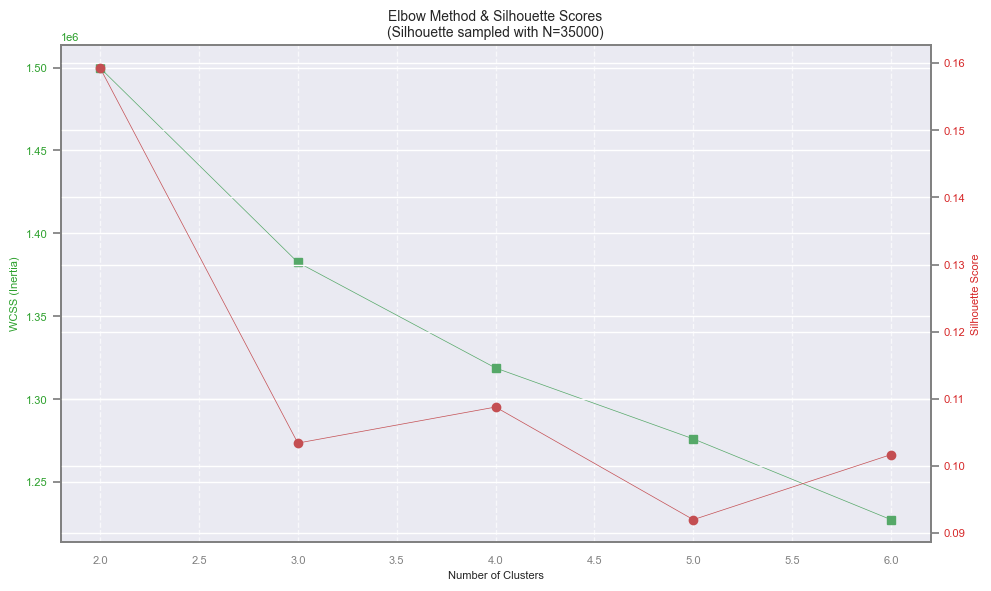

In [356]:
plot_kmeans_wcss_silhouette(X_diab_scaled_df, 
                            max_clusters    = 6, 
                            random_state    = RANDOM_STATE, 
                            sample_size     = 35000)

In [357]:
diab_engineered_df.drop_duplicates(inplace=True)

In [360]:
clusters = 3
# Fit model for k=3
kmeans_diab = KMeans(n_clusters = clusters, random_state = RANDOM_STATE, n_init = 10)
kmeans_diab.fit(X_diab_scaled_df)

kmeans_diab.labels_

array([1, 0, 1, ..., 2, 0, 0], shape=(69057,), dtype=int32)

In [361]:
#  Create new df of scaled & cleaned engineered features and then add cluster labels and target variable

diab_engineered_scaled_df                    = X_diab_scaled_df.copy()
diab_engineered_scaled_df['Cluster']         = kmeans_diab.labels_
diab_engineered_scaled_df['Diabetes_binary'] = diab_unscale_df['Diabetes_binary'].values

diab_engineered_scaled_df

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,Sex,Age,Education,Income,Risk_Count,Total_Bad_Health_Days,Age_BMI_Interaction,BMI_Cat,Cluster,Diabetes_binary
0,0.866388,-1.064751,0.160773,-0.553424,-0.964500,-0.260708,-0.421525,0.660141,-1.239305,0.524704,...,1.091218,-1.610781,1.068379,1.079554,-0.662575,1.650397,-1.526696,-0.141115,1,0
1,0.866388,0.939187,0.160773,-0.553424,1.036806,3.835704,-0.421525,-1.514828,0.806904,-1.905836,...,1.091218,1.188121,1.068379,1.079554,1.825170,-0.640495,0.551270,-0.141115,0,0
2,-1.154218,-1.064751,0.160773,-0.553424,-0.964500,-0.260708,-0.421525,0.660141,0.806904,0.524704,...,1.091218,1.537984,1.068379,1.079554,-1.491823,0.014046,0.811015,-0.141115,1,0
3,0.866388,0.939187,0.160773,-0.273623,1.036806,-0.260708,-0.421525,0.660141,0.806904,0.524704,...,1.091218,0.838258,1.068379,1.079554,0.995922,-0.444132,0.511309,-0.141115,0,0
4,-1.154218,-1.064751,0.160773,-0.133722,1.036806,-0.260708,-0.421525,0.660141,0.806904,0.524704,...,-0.916408,-0.211330,0.096873,1.079554,-0.662575,-0.640495,-0.247948,-0.141115,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69052,-1.154218,0.939187,0.160773,0.985485,-0.964500,-0.260708,-0.421525,-1.514828,-1.239305,0.524704,...,-0.916408,-0.911056,-0.874632,-2.137961,-0.662575,-0.640495,-0.347850,1.080367,0,1
69053,-1.154218,0.939187,0.160773,-0.133722,1.036806,-0.260708,2.372338,-1.514828,0.806904,0.524704,...,1.091218,0.488395,-1.846137,0.160264,0.995922,-0.640495,0.331485,-0.141115,0,1
69054,0.866388,0.939187,0.160773,-0.693325,-0.964500,-0.260708,2.372338,-1.514828,0.806904,-1.905836,...,-0.916408,1.537984,1.068379,-0.759026,0.995922,0.341316,0.681142,-1.362597,2,1
69055,0.866388,0.939187,0.160773,-1.672631,-0.964500,-0.260708,-0.421525,-1.514828,-1.239305,-1.905836,...,-0.916408,0.838258,-2.817642,-0.759026,0.166673,-0.640495,-0.587616,-2.584078,0,1


In [369]:
# 1. Create a dataframe with Unscaled features + Cluster Labels
# (You already have diab_unscale_df from your prepare_data function)
profile_df = diab_unscale_df.copy()
profile_df['Cluster'] = kmeans_diab.labels_
profile_df


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,DiffWalk,Sex,Age,Education,Income,Risk_Count,Total_Bad_Health_Days,Age_BMI_Interaction,BMI_Cat,Cluster
0,0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,4.0,6.0,8.0,1.0,35.0,104.0,2,1
1,0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,12.0,6.0,8.0,4.0,0.0,312.0,2,0
2,0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,13.0,6.0,8.0,0.0,10.0,338.0,2,1
3,0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,11.0,6.0,8.0,3.0,3.0,308.0,2,0
4,0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,8.0,5.0,8.0,1.0,0.0,232.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69052,1,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,4.0,1.0,1.0,0.0,222.0,3,0
69053,1,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,10.0,3.0,6.0,3.0,0.0,290.0,2,0
69054,1,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,13.0,6.0,4.0,3.0,15.0,325.0,1,2
69055,1,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,11.0,2.0,4.0,2.0,0.0,198.0,0,0


In [376]:

#  Group by Cluster and calculate the mean
cluster_profile = profile_df.groupby('Cluster').mean()
cluster_profile.T

Cluster,0,1,2
Diabetes_binary,0.658901,0.206282,0.747159
HighBP,0.839743,0.150293,0.775351
HighChol,0.710346,0.230628,0.705387
CholCheck,0.993708,0.947249,0.985240
BMI,31.299829,26.837456,32.890849
Smoker,0.543997,0.336754,0.619705
Stroke,0.067175,0.006243,0.164428
HeartDiseaseorAttack,0.192924,0.012251,0.320369
PhysActivity,0.687418,0.838393,0.448044
Fruits,0.603809,0.645884,0.533653


In [375]:

# Inspect the key differences (Focusing on the engineered features helps)
cluster_profile[['Age', 'BMI', 'GenHlth', 'Risk_Count', 'Total_Bad_Health_Days', 'Diabetes_binary']].T

Cluster,0,1,2
Age,9.968705,6.801053,9.005387
BMI,31.299829,26.837456,32.890849
GenHlth,2.870302,2.183067,4.136531
Risk_Count,2.354185,0.736169,2.585240
Total_Bad_Health_Days,3.177863,3.972805,35.349299
Diabetes_binary,0.658901,0.206282,0.747159


In [385]:
# A. Cluster Profiling (using UN-scaled data for interpretation)
# Add cluster labels to the unscaled features
X_diab_unscale_labeled = X_diab_unscale_df.copy()
X_diab_unscale_labeled['Cluster'] = kmeans_diab.labels_
X_diab_unscale_labeled['Diabetes_binary'] = diab_unscale_df['Diabetes_binary'].values

# Calculate means
cluster_profile = X_diab_unscale_labeled.groupby('Cluster').mean().T
cluster_profile.head()

Cluster,0,1,2
HighBP,0.839743,0.150293,0.775351
HighChol,0.710346,0.230628,0.705387
CholCheck,0.993708,0.947249,0.985240
BMI,31.299829,26.837456,32.890849
Smoker,0.543997,0.336754,0.619705


In [386]:
# Target Distribution
# calculate the percentage breakdown of Diabetes vs. No Diabetes within each cluster.
# value_counts() counts how many 0s (No Diabetes) and 1s (Diabetes) are in that specific cluster.
# unstack() pivots the 0 and 1 values into their own columns, making the table easier to read.
# normalize=True converts those raw counts into percentages (proportions between 0 and 1).
target_dist = X_diab_unscale_labeled.groupby('Cluster')['Diabetes_binary'].value_counts(normalize=True).unstack()

print(f"Cluster Profile (Means of Original Features):\n{cluster_profile}\n")
print(f"\nTarget Distribution (Proportion of Diabetes):\n{target_dist}")


Cluster Profile (Means of Original Features):
Cluster                         0           1           2
HighBP                   0.839743    0.150293    0.775351
HighChol                 0.710346    0.230628    0.705387
CholCheck                0.993708    0.947249    0.985240
BMI                     31.299829   26.837456   32.890849
Smoker                   0.543997    0.336754    0.619705
Stroke                   0.067175    0.006243    0.164428
HeartDiseaseorAttack     0.192924    0.012251    0.320369
PhysActivity             0.687418    0.838393    0.448044
Fruits                   0.603809    0.645884    0.533653
Veggies                  0.769957    0.840851    0.708044
HvyAlcoholConsump        0.034173    0.062622    0.027970
AnyHealthcare            0.972152    0.939875    0.940221
NoDocbcCost              0.052348    0.077760    0.227454
GenHlth                  2.870302    2.183067    4.136531
MentHlth                 1.170298    2.240421   12.752694
PhysHlth                 2

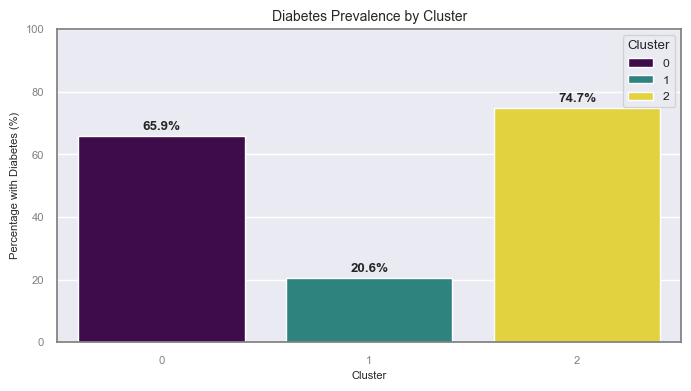

In [384]:
# Create a bar chart for Diabetes Rate per Cluster
target_dist_pct = target_dist[1] * 100 # Percentage of Diabetes=1
plt.figure(figsize=(7,4))
sns.barplot(x=target_dist_pct.index, hue=target_dist_pct.index, y=target_dist_pct.values, palette='viridis')
plt.title('Diabetes Prevalence by Cluster')
plt.ylabel('Percentage with Diabetes (%)')
plt.xlabel('Cluster')
plt.ylim(0, 100)
for i, v in enumerate(target_dist_pct.values):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

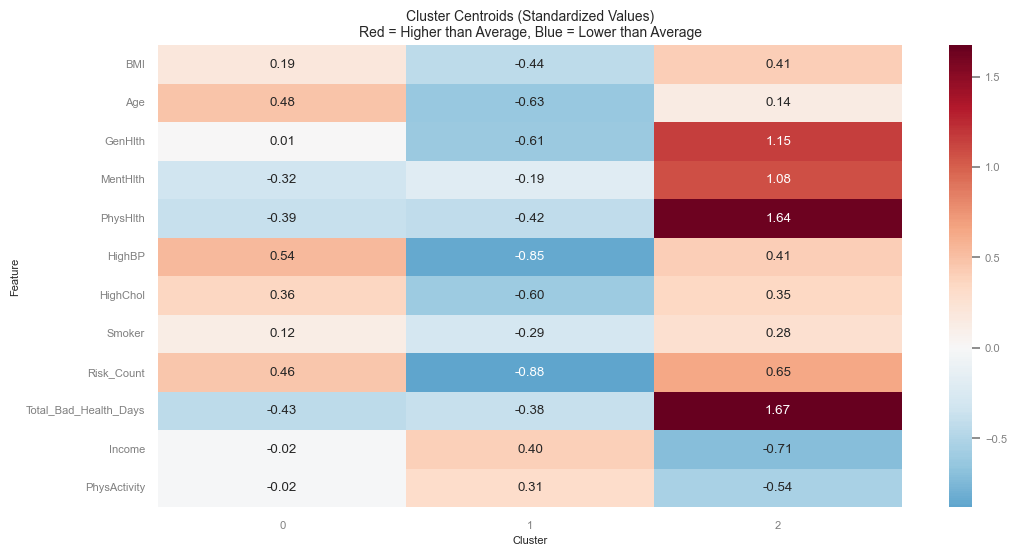

In [387]:
# We will use the Scaled Centroids for the Heatmap (to show relative importance)
centroids_scaled = pd.DataFrame(
    kmeans_diab.cluster_centers_, 
    columns=X_diab_scaled_df.columns
)
centroids_scaled.index.name = 'Cluster'

# Select key features for a cleaner heatmap (removing redundant or less informative ones)
key_features = [
    'BMI', 'Age', 'GenHlth', 'MentHlth', 'PhysHlth', 
    'HighBP', 'HighChol', 'Smoker', 'Risk_Count', 
    'Total_Bad_Health_Days', 'Income', 'PhysActivity'
]

plt.figure(figsize=(12, 6))
sns.heatmap(centroids_scaled[key_features].T, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Cluster Centroids (Standardized Values)\nRed = Higher than Average, Blue = Lower than Average')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.savefig('cluster_heatmap.png', bbox_inches='tight')

<font color = 'plum'>

#### Cluster 0: "The Managed Chronic Group"

Characteristics: High rates of HighBP and HighChol, and the highest Age.

Health Status: despite high risk factors, they report low "Bad Health Days" (Physical/Mental health is okay).

Diabetes Rate: High (~66%).

Takeaway: These are older individuals with metabolic conditions, but they seem to be functioning relatively well.

#### Cluster 1: "The Healthy Baseline"

Characteristics: Lowest BMI, lowest Age, lowest Risk_Count.

Health Status: Excellent (GenHlth score is low, which means Good/Excellent).

Average Age ~6.8. This maps to the 45–54 age range.

Diabetes Rate: Lowest (~21%).

Takeaway: The healthiest segment of the population.

#### Cluster 2: "The Severe / Comorbid Group"

Characteristics: Highest BMI and extremely high Total_Bad_Health_Days (averaging ~35 days combined).

Health Status: They report very poor GenHlth and high difficulty walking (DiffWalk).

Diabetes Rate: Highest (~75%).

Average Age ~9.9. This maps to the 60–69 age range (Retirement age).

Takeaway: This group is suffering. Diabetes here is likely accompanied by significant complications and poor quality of life.



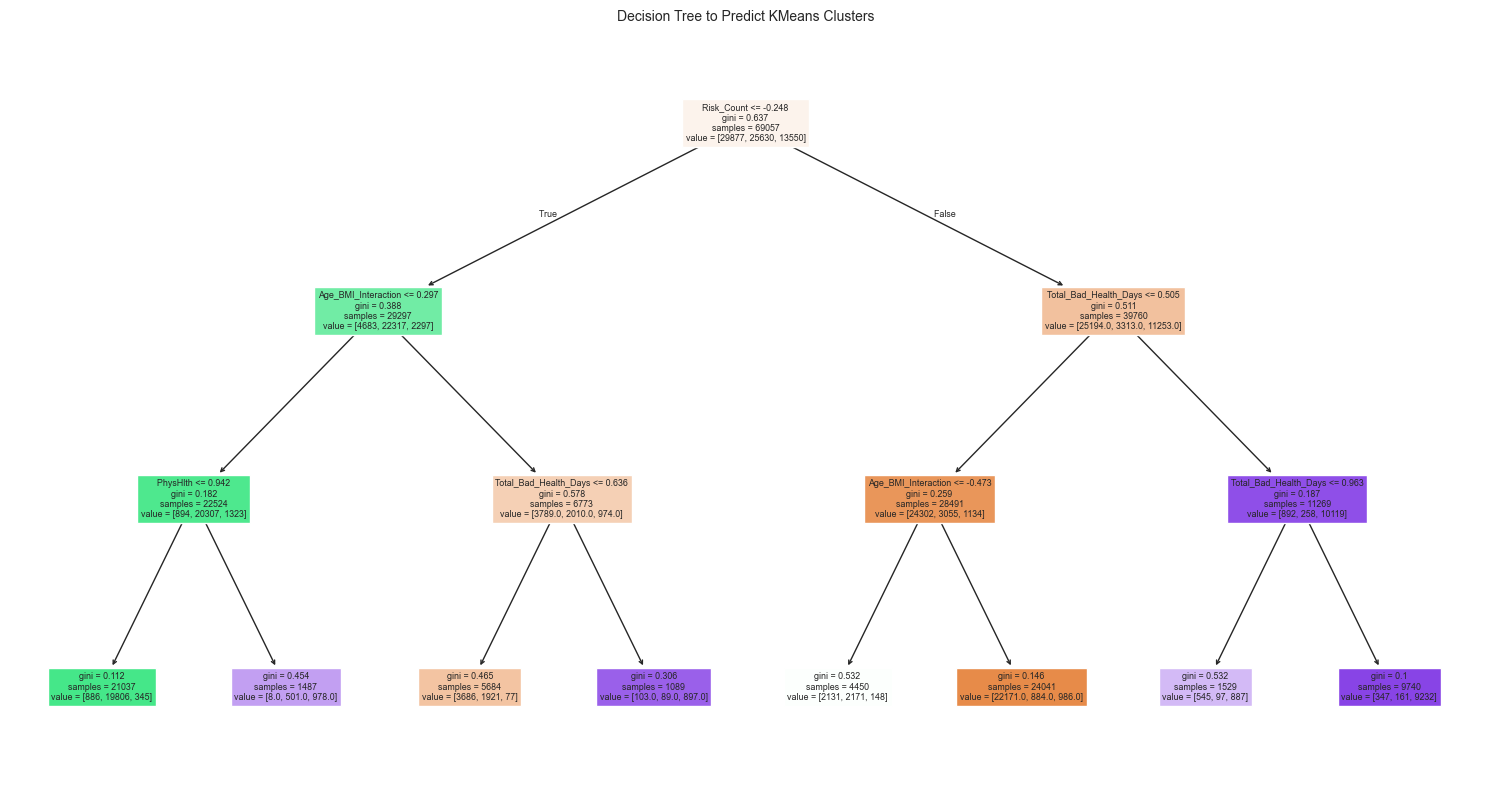

In [395]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# X = scaled features, y = Cluster Labels
dt = DecisionTreeClassifier(max_depth=3) 
dt.fit(X_diab_scaled_df, kmeans_diab.labels_)

plt.figure(figsize=(15,8))
plot_tree(dt, feature_names=X_diab_scaled_df.columns, filled=True)
plt.title('Decision Tree to Predict KMeans Clusters')
plt.tight_layout()
plt.show()

## <font color='plum'> 3.c. Chronic Kidney Disease Dataset

Contains comprehensive data for 1,659 patients, including 54 variables spanning medical history, lab results, medication usage, quality of life, and environmental
exposure. Ideal for regression, classification, and clustering analyses.
https://www.kaggle.com/datasets/rabieelkharoua/chronic-kidney-disease-dataset-analysis

### Load & Clean - CKD

In [390]:
file_path = "rabieelkharoua/chronic-kidney-disease-dataset-analysis"
file_name = "Chronic_Kidney_Dsease_data.csv"

# Load the latest version
df_3c = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)

# df_3c.head()
df_3c.columns       = df_3c.columns.str.strip()
columns_to_drop     = ['PatientID', 'DoctorInCharge']  # Columns to drop
df_3c.drop(columns  = columns_to_drop, inplace = True, errors = 'ignore')  # Drop specified columns
target_col          = 'Diagnosis'
categorical_cols    = []
numeric_cols        = []


# for stupid confusion matrix plot
classification_dict_CKD = {
    0: 'No CKD',
    1: 'CKD'
}

In [391]:
df_3c

,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MuscleCramps,Itching,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis
0,71,0,0,0,2,31.069414,1,5.128112,1.676220,0.240386,...,4.518513,7.556302,76.076800,0,0,1,1.018824,4.966808,9.871449,1
1,34,0,0,1,3,29.692119,1,18.609552,8.377574,6.503233,...,2.202222,6.836766,40.128498,0,0,0,3.923538,8.189275,7.161765,1
2,80,1,1,0,1,37.394822,1,11.882429,9.607401,2.104828,...,5.967271,2.144722,92.872842,0,1,1,1.429906,7.624028,7.354632,1
3,40,0,2,0,1,31.329680,0,16.020165,0.408871,6.964422,...,2.176387,7.077188,90.080321,0,0,0,3.226416,3.282688,6.629587,1
4,43,0,1,1,2,23.726311,0,7.944146,0.780319,3.097796,...,6.800993,3.553118,5.258372,0,0,1,0.285466,3.849498,1.437385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,90,0,0,1,2,39.677059,1,1.370151,4.157954,8.602873,...,6.972093,2.138976,81.102765,0,0,0,0.951836,9.547583,2.046212,0
1655,34,0,0,2,1,28.922015,0,3.372073,9.647525,9.836919,...,0.465297,7.911566,10.600428,0,1,0,3.604147,1.609847,0.324417,0
1656,84,0,0,2,3,21.951219,0,15.825955,7.349964,5.038194,...,2.281970,0.015531,69.633427,0,0,0,0.801955,5.768617,4.935108,0
1657,90,0,0,2,2,24.964149,0,12.967462,0.618614,4.557577,...,0.257814,3.432765,31.858023,0,0,0,0.560298,2.744519,0.322592,1


In [392]:
# show distribution of target variable
df_3c['Diagnosis'].value_counts()

Diagnosis
1    1524
0     135
Name: count, dtype: int64

In [393]:
CKD_engineered_df = engineer_features_ckd(df_3c, drop_originals = False)

# Check the new shape
print(f"Original Feature Count: {df_3c.shape[1]}")
print(f"New Feature Count: {CKD_engineered_df.shape[1]}")

Original Feature Count: 52
New Feature Count: 61


In [394]:
CKD_engineered_df

,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,Diagnosis,BUN_Creatinine_Ratio,Cholesterol_Ratio,MAP,FamilyHistoryScore,ExposureScore,Symptom_Score,Lifestyle_Risk_Score,Metabolic_Stress,Electrolyte_Homeostasis_Score
0,71,0,0,0,2,31.069414,1,5.128112,1.676220,0.240386,...,1,5.159857,9.451682,93.000000,0,0,22.630953,1.256499,2.545740e+05,4.351878
1,34,0,0,1,3,29.692119,1,18.609552,8.377574,6.503233,...,1,9.927197,2.163179,84.666667,2,0,14.722613,1.930817,3.593300e+05,3.374655
2,80,1,1,0,1,37.394822,1,11.882429,9.607401,2.104828,...,1,10.745169,14.164531,119.666667,0,1,17.641482,1.594338,8.849652e+05,3.493184
3,40,0,2,0,1,31.329680,0,16.020165,0.408871,6.964422,...,1,7.662962,4.034854,82.333333,0,0,23.476715,0.801300,6.909847e+05,3.942641
4,43,0,1,1,2,23.726311,0,7.944146,0.780319,3.097796,...,1,3.081146,11.961053,76.666667,0,0,14.049889,0.397352,1.910290e+05,2.625237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,90,0,0,1,2,39.677059,1,1.370151,4.157954,8.602873,...,0,10.590084,5.977452,102.666667,0,0,17.626082,1.068533,1.008050e+06,3.524392
1655,34,0,0,2,1,28.922015,0,3.372073,9.647525,9.836919,...,0,46.431262,9.338641,111.000000,0,1,14.066795,0.168665,2.703637e+05,3.834765
1656,84,0,0,2,3,21.951219,0,15.825955,7.349964,5.038194,...,0,56.374587,4.266000,107.333333,0,0,12.896617,0.791586,4.224282e+05,4.776729
1657,90,0,0,2,2,24.964149,0,12.967462,0.618614,4.557577,...,1,11.124152,9.996976,112.333333,0,0,9.687011,0.648609,4.020096e+05,4.092358


In [ ]:
X_train_CKD, X_test_CKD, y_train_CKD, y_test_CKD, X_CKD = prepare_data(
    df              = CKD_engineered_df,
    # df              = df_3c,    
    target_col      = 'Diagnosis',
    test_size       = TEST_SIZE,
    random_state    = RANDOM_STATE
)

print("X_train:", X_train_CKD.shape)
print("y_train:", y_train_CKD.shape)
print("X_test:", X_test_CKD.shape)
print("y_test:", y_test_CKD.shape)
print(f'Updated feature list: {X_CKD.columns.tolist()}\n')

Target variable 'Diagnosis' encoded successfully.
Dropped rows with NaNs and duplicates.
Initial rows: 1659, Final rows: 1659
Percentage of data retained: 100.00%

Applied type coercion to feature columns.
Data Split: Training set size = 1327, Test set size = 332

No scaling applied. Returning original feature values.
X_train: (1327, 60)
y_train: (1327,)
X_test: (332, 60)
y_test: (332,)
Updated feature list: ['Age', 'Gender', 'Ethnicity', 'SocioeconomicStatus', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryKidneyDisease', 'FamilyHistoryHypertension', 'FamilyHistoryDiabetes', 'PreviousAcuteKidneyInjury', 'UrinaryTractInfections', 'SystolicBP', 'DiastolicBP', 'FastingBloodSugar', 'HbA1c', 'SerumCreatinine', 'BUNLevels', 'GFR', 'ProteinInUrine', 'ACR', 'SerumElectrolytesSodium', 'SerumElectrolytesPotassium', 'SerumElectrolytesCalcium', 'SerumElectrolytesPhosphorus', 'HemoglobinLevels', 'CholesterolTotal', 'Choles

In [ ]:
file_path  = "rabieelkharoua/chronic-kidney-disease-dataset-analysis"
file_name  = "Chronic_Kidney_Dsease_data.csv"
dataset_3c = 'Chronic Kidney Disease Prediction'

# Load latest version
df_3c = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)

df_3c.columns       = df_3c.columns.str.strip()
columns_to_drop     = ['PatientID', 'DoctorInCharge']
df_3c.drop(columns  = columns_to_drop, inplace = True, errors = 'ignore')

# for stupid confusion matrix plot
classification_dict_CKD = {
    0: 'No CKD',
    1: 'CKD'
}

X_train_CKD, X_test_CKD, y_train_CKD, y_test_CKD, X_CKD = prepare_data(
    df              = df_3c,
    target_col      = 'Diagnosis',
    test_size       = TEST_SIZE,
    random_state    = RANDOM_STATE
)

scaler_CKD = StandardScaler()
scaler_CKD.fit(X_CKD)


print("X_train:", X_train_CKD.shape)
print("y_train:", y_train_CKD.shape)
print("X_test:", X_test_CKD.shape)
print("y_test:", y_test_CKD.shape)


Target variable 'Diagnosis' encoded successfully.
Dropped rows with NaNs. Initial rows: 1659, Final rows: 1659
Percentage of data retained: 100.00%

Applied robust data type coercion to feature columns.
Data Split: Training set size = 1327, Test set size = 332

--- Manual Feature Scaling ---
Scaling Complete.

X_train: (1327, 51)
y_train: (1327,)
X_test: (332, 51)
y_test: (332,)


### Elbow Method & Silhouette

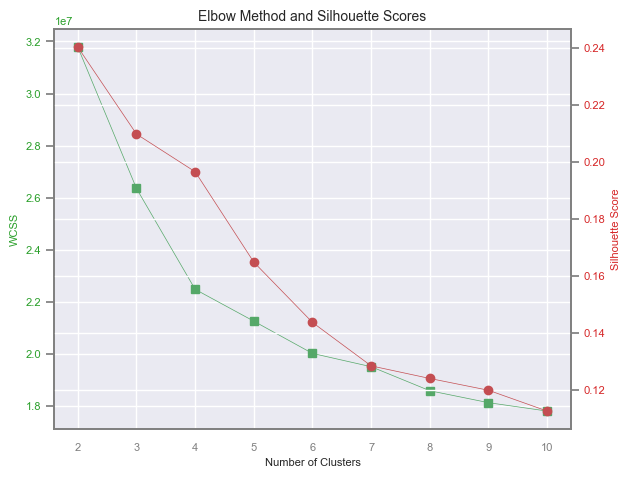

In [ ]:
plot_kmeans_wcss_silhouette(X_CKD, max_clusters = 10, random_state = RANDOM_STATE, sample_size = 3000)

In [ ]:
K           = 6
kmeans_full = KMeans(n_clusters = K, random_state = RANDOM_STATE, n_init = 10)
kmeans_full.fit(X_CKD)

print(f'length of labels: {len(kmeans_full.labels_)}')

X_CKD['Cluster'] = kmeans_full.labels_

length of labels: 1659


In [35]:
# Get the scaled cluster centers, ensuring correct column names are used (from feature_cols)
# The cluster_centers_ array has shape (k, number_of_features)
#  values represent how many standard deviations the cluster's mean is from the overall dataset mean (mu=0)

scaled_centroids = pd.DataFrame(kmeans_full.cluster_centers_, columns = X_CKD.columns[:-1]) # Exclude 'Cluster' column
# Display the size of each cluster
cluster_sizes = X_CKD['Cluster'].value_counts().sort_index().to_frame(name='Size')
print(f"Cluster Sizes\n{cluster_sizes}\n")


print(f"\nScaled Cluster Centroids (Mean Feature Values Relative to Full Data Mean)\n\n{scaled_centroids}")
# scaled_centroids

Cluster Sizes
         Size
Cluster      
0         304
1         221
2         312
3         234
4         282
5         306


Scaled Cluster Centroids (Mean Feature Values Relative to Full Data Mean)

         Age    Gender  Ethnicity  SocioeconomicStatus  EducationLevel  \
0  54.062500  0.552632   0.687500             1.029605        1.707237   
1  55.348416  0.538462   0.755656             0.990950        1.710407   
2  54.657051  0.490385   0.641026             0.958333        1.685897   
3  53.568376  0.457265   0.683761             0.978632        1.666667   
4  55.436170  0.492908   0.780142             0.907801        1.656028   
5  53.692810  0.552288   0.741830             1.000000        1.728758   

         BMI   Smoking  AlcoholConsumption  PhysicalActivity  DietQuality  \
0  27.020985  0.345395            9.900885          4.956999     4.935417   
1  27.378083  0.276018            9.776994          4.931126     5.225967   
2  27.852935  0.307692           10.102660     

## Notes


### <font color='plum'><i>When would we use the k-means algorithm?  </i> 

K-means is a clustering algorithm used when you want to **group similar data points into clusters without prior labels**. It’s an **unsupervised learning method**, so it’s ideal when you don’t have predefined categories. Here are common scenarios where K-means is useful:

#### **When to Use K-means**

1.  **Customer Segmentation**
    *   Group customers based on purchasing behavior, demographics, or preferences.

2.  **Market Basket Analysis**
    *   Identify clusters of products that are often bought together.

3.  **Image Compression & Segmentation**
    *   Reduce colors in an image by clustering pixel values.

4.  **Document or Text Clustering**
    *   Organize articles, reviews, or search results into topics.

5.  **Anomaly Detection**
    *   Detect outliers by finding points far from cluster centroids.

#### ⚠️ **When NOT to Use K-means**

*   If clusters are **not spherical** or have **different sizes/densities**.
*   If data has **many categorical variables** (K-means works best with numeric data).
*   If you need **hierarchical relationships** between clusters.

-------------

### <font color='plum'><i>When would the Silhouette score be used as opposed to the elbow method?</i>

#### **Elbow Method**

*   **Purpose:** - Helps determine the optimal number of clusters by looking at the within-cluster sum of squares (WCSS).
*   **How it works:**  
    Plot WCSS vs. number of clusters (k). The "elbow" point—where the rate of decrease sharply changes—suggests the best k.
*   **When to use:**
    *   When you want a quick heuristic for choosing k.
    *   Works well when clusters are relatively spherical and evenly sized.
*   **Limitation:**
    *   Subjective: The elbow is not always clear.
    *   Doesn’t measure actual cluster quality, just compactness.

#### **Silhouette Score**

*   **Purpose:** - measures how well each point fits within its cluster compared to other clusters.
*   **How it works:**  
    For each point:
    *   Compute **a** = average distance to points in its own cluster.
    *   Compute **b** = average distance to points in the nearest other cluster.
    *   `Silhouette = (b - a) / max(a, b)`, ranges from -1 to 1.
*   **When to use:**
    *   When you want an objective metric for cluster quality.
    *   Useful for comparing different k values or different clustering algorithms.
*   **Advantage:**
    *   Gives a clear numeric score for cluster separation and cohesion.
*   **Limitation:**
    *   Computationally heavier than Elbow Method for large datasets.

#### **Summary**

*   Use Elbow Method for a quick estimate of k.
*   Use Silhouette Score when you need a quantitative measure of cluster quality or to validate the choice of k.


---------------

### <font color='plum'><i>Why do we use k-means only with the Euclidean metric? </i>


K-means generally runs with the Euclidean distance because the centroid minimizes the sum of squared distances only with this metric. For example, if we have points (1, 1), (1, -1), and (-2, 0), then the centroid is (0, 0) and the sum of squared distances is 8. This is the minimum possible sum of squared distances. The sum of the Manhattan distances, on the other hand, is 6. This can be improved upon by choosing the center point (1, 0), whose summed Manhattan distance is 5. 

K-means is typically used with the **Euclidean distance metric** because of how the algorithm is designed:

 1. **Centroid Calculation**

*   K-means minimizes the **sum of squared distances** between points and their cluster centroid.
*   The centroid is computed as the **mean of all points in the cluster**, which is mathematically aligned with Euclidean geometry.
*   If you use another metric (like Manhattan or cosine), the mean is no longer the optimal representative point for minimizing that metric.


 2. **Objective Function**

*   The K-means objective is:
    \[
    \text{minimize } \sum\_{i=1}^{k} \sum\_{x \in C\_i} | x - \mu\_i |^2
    ]
    where (\mu\_i) is the cluster mean.
*   This formulation assumes **L2 norm (Euclidean)** because squared distances are based on Euclidean space.



 3. **Why Not Other Metrics?**

*   For Manhattan distance (L1 norm), the optimal center is the **median**, not the mean.
*   For cosine similarity, the concept of a "mean" vector doesn’t minimize cosine distance.
*   Using other metrics without changing the centroid update rule breaks the algorithm’s convergence guarantees.


 **Alternatives**

*   If you need other distance metrics:
    *   Use **K-medoids (PAM)** for Manhattan or arbitrary metrics.
    *   Use **Spectral Clustering** or **DBSCAN** for non-Euclidean spaces.


With k-means, we pick the cluster centroids arbitrarily. (Note: The “centroid” is the geometrical center of the cluster — the average of the points in the cluster. The “cluster” is the set of points.)

## Misc.

In [ ]:

# # 2. Attach labels to original data
# df_labeled              = diab_engineered_scaled_df.copy()
# df_labeled['Cluster']   = kmeans_diab.labels_
# print(f'length of labels: {len(kmeans_diab.labels_)}')



In [ ]:
# # Get the scaled cluster centers, ensuring correct column names are used (from feature_cols)
# # The cluster_centers_ array has shape (k, number_of_features)
# #  values represent how many standard deviations the cluster's mean is from the overall dataset mean (mu=0)


# scaled_centroids = kmeans_3.cluster_centers_
# scaled_centroids_df = pd.DataFrame(scaled_centroids, columns = X_diab_final_df.columns)
# scaled_centroids_df

In [ ]:
# # Display the size of each cluster
# cluster_sizes = X['Cluster'].value_counts().sort_index().to_frame(name='Size')
# print(f"Cluster Sizes\n{cluster_sizes}\n")


In [ ]:

# print(f"\nScaled Cluster Centroids (Mean Feature Values Relative to Full Data Mean)\n\n{scaled_centroids}")
# # scaled_centroids

In [ ]:
# df_3a = df_3a.drop_duplicates().reset_index(drop=True)

In [ ]:
# # 1. Add your cluster labels to the ORIGINAL (unscaled) dataframe
# # (Assuming 'df_diabetes' is your original dataframe loaded from CSV)
# df_3a['Cluster_Label'] = kmeans_3.labels_

# # 2. Group by the new Cluster Label and take the mean
# # This gives you the REAL units (Age in years, BMI in points, etc.)
# real_values_profile = df_3a.groupby('Cluster_Label')[['Diabetes_binary', 'Age', 'BMI', 'PhysHlth', 'MentHlth', 'HighBP']].mean()

In [ ]:
# print("--- Real, Interpretable Averages ---")
# real_values_profile

In [ ]:
# Optional: For 'Distance Metrics' requirement
# from sklearn_extra.cluster import KMedoids
# kmedoids = KMedoids(n_clusters=4, metric='manhattan', init='k-medoids++')
# kmedoids.fit(X_diab_final_df)